In [8]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/emotion-analysis-based-on-text/emotion_sentimen_dataset.csv


In [9]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [10]:
import pandas as pd

df = pd.read_csv('/kaggle/input/emotion-analysis-based-on-text/emotion_sentimen_dataset.csv')
df = df[df['Emotion'] != 'boredom']
min_count = df['Emotion'].value_counts().min()
df = df.groupby('Emotion').apply(lambda x: x.sample(n=min(300, len(x)), random_state=42)).reset_index(drop=True)
print(df.head(5))


   Unnamed: 0                                               text Emotion
0      833975  i listen to when i feel discouraged as a write...   anger
1      647817  i feel a perverse thrill as i say this despite...   anger
2      148525  i would continue to feel so irritated and even...   anger
3      291010  i feel afraid inside i realize that im angry i...   anger
4      792290  i feel he broke up with his ex for her not tru...   anger


/tmp/ipykernel_30/276226412.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Emotion').apply(lambda x: x.sample(n=min(300, len(x)), random_state=42)).reset_index(drop=True)


In [11]:
unique_values = df['Emotion'].value_counts()
unique_values

Emotion
anger         300
empty         300
enthusiasm    300
fun           300
happiness     300
hate          300
love          300
neutral       300
relief        300
sadness       300
surprise      300
worry         300
Name: count, dtype: int64

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
label_mapping = {label: idx for idx, label in enumerate(df['Emotion'].unique())}
train_df['Emotion'] = train_df['Emotion'].map(label_mapping)
test_df['Emotion'] = test_df['Emotion'].map(label_mapping)


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
train_dataset = EmotionDataset(train_df['text'].tolist(), train_df['Emotion'].tolist(), tokenizer)
test_dataset = EmotionDataset(test_df['text'].tolist(), test_df['Emotion'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Emotion'].unique()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
criterion = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 360/360 [01:03<00:00,  5.70it/s]


Epoch 1 average loss: 0.8853


Epoch 2/10: 100%|██████████| 360/360 [01:05<00:00,  5.54it/s]


Epoch 2 average loss: 0.1855


Epoch 3/10: 100%|██████████| 360/360 [01:07<00:00,  5.33it/s]


Epoch 3 average loss: 0.0803


Epoch 4/10: 100%|██████████| 360/360 [01:07<00:00,  5.32it/s]


Epoch 4 average loss: 0.0396


Epoch 5/10: 100%|██████████| 360/360 [01:07<00:00,  5.32it/s]


Epoch 5 average loss: 0.0212


Epoch 6/10: 100%|██████████| 360/360 [01:07<00:00,  5.34it/s]


Epoch 6 average loss: 0.0119


Epoch 7/10: 100%|██████████| 360/360 [01:07<00:00,  5.33it/s]


Epoch 7 average loss: 0.0064


Epoch 8/10: 100%|██████████| 360/360 [01:07<00:00,  5.33it/s]


Epoch 8 average loss: 0.0164


Epoch 9/10: 100%|██████████| 360/360 [01:07<00:00,  5.33it/s]


Epoch 9 average loss: 0.0088


Epoch 10/10: 100%|██████████| 360/360 [01:07<00:00,  5.32it/s]

Epoch 10 average loss: 0.0069


In [24]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [26]:
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        79
           1       1.00      1.00      1.00        68
           2       1.00      0.98      0.99        57
           3       0.98      0.97      0.98        62
           4       0.98      0.98      0.98        51
           5       1.00      1.00      1.00        68
           6       0.98      1.00      0.99        49
           7       0.89      0.95      0.92        62
           8       0.96      0.96      0.96        54
           9       1.00      1.00      1.00        63
          10       1.00      1.00      1.00        49
          11       1.00      1.00      1.00        58

    accuracy                           0.98       720
   macro avg       0.98      0.98      0.98       720
weighted avg       0.98      0.98      0.98       720



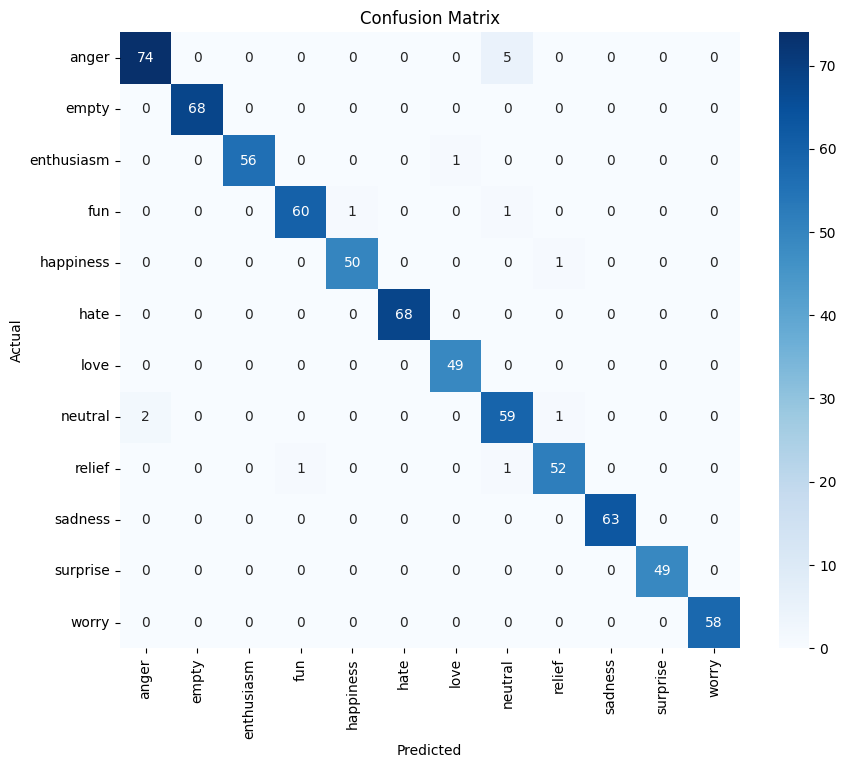

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

